In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import eli5
from eli5.sklearn import PermutationImportance
from sklearn import tree
import graphviz
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots
import shap  # package used to calculate Shap values

In [15]:
# import Dataset to play with it
train= pd.read_csv("/home/altieris/datascience/data/santander-customer-transaction-prediction/train.csv")
test = pd.read_csv('/home/altieris/datascience/data/santander-customer-transaction-prediction/test.csv')

 <a id="5"></a> <br>
# 5- Machine Learning Explainability for Santander
In this section, I want to try extract insights from models with the help of this excellent [**Course**](https://www.kaggle.com/learn/machine-learning-explainability) in Kaggle.
The Goal behind of ML Explainability for Santander is:
1. All features are senseless named.(var_1, var2,...) but certainly the importance of each one is different!
1. Extract insights from models.
1. Find the most inmortant feature in models.
1. Affect of each feature on the model's predictions.
<img src='http://s8.picofile.com/file/8353215168/ML_Explain.png'>

As you can see from the above, we will refer to three important and practical concepts in this section and try to explain each of them in detail.

 <a id="51"></a> <br>
## 5-1 Permutation Importance
 In this section we will answer following question:
 1. What features have the biggest impact on predictions?
 1. how to extract insights from models?

### Prepare our data for our model

In [16]:
cols=["target","ID_code"]
X = train.drop(cols,axis=1)
y = train["target"]


In [17]:
X_test  = test.drop("ID_code",axis=1)

### Create  a sample model to calculate which feature are more important.

In [18]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
rfc_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

 <a id="52"></a> <br>
## 5-2 How to calculate and show importances?

### Here is how to calculate and show importances with the [eli5](https://eli5.readthedocs.io/en/latest/) library:

In [19]:
perm = PermutationImportance(rfc_model, random_state=1).fit(val_X, val_y)

In [20]:
eli5.show_weights(perm, feature_names = val_X.columns.tolist(), top=150)

Weight,Feature
0.0002 ± 0.0002,var_110
0.0001 ± 0.0001,var_157
0.0001 ± 0.0001,var_162
0.0001 ± 0.0001,var_42
0.0001 ± 0.0002,var_170
0.0001 ± 0.0002,var_174
0.0001 ± 0.0001,var_188
0.0001 ± 0.0001,var_147
0.0001 ± 0.0001,var_197
0.0001 ± 0.0001,var_47


<a id="53"></a> <br>
## 5-3 What can be inferred from the above?
1. As you move down the top of the graph, the importance of the feature decreases.
1. The features that are shown in green indicate that they have a positive impact on our prediction
1. The features that are shown in white indicate that they have no effect on our prediction
1. The features shown in red indicate that they have a negative impact on our prediction
1.  The most important feature was **Var_110**.

<a id="54"></a> <br>
## 5-4 Partial Dependence Plots
While **feature importance** shows what **variables** most affect predictions, **partial dependence** plots show how a feature affects predictions.[6][7]
and partial dependence plots are calculated after a model has been fit. [partial-plots](https://www.kaggle.com/dansbecker/partial-plots)

In [21]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(train_X, train_y)

For the sake of explanation, I use a Decision Tree which you can see below.

In [22]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]

In [23]:
tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=features)

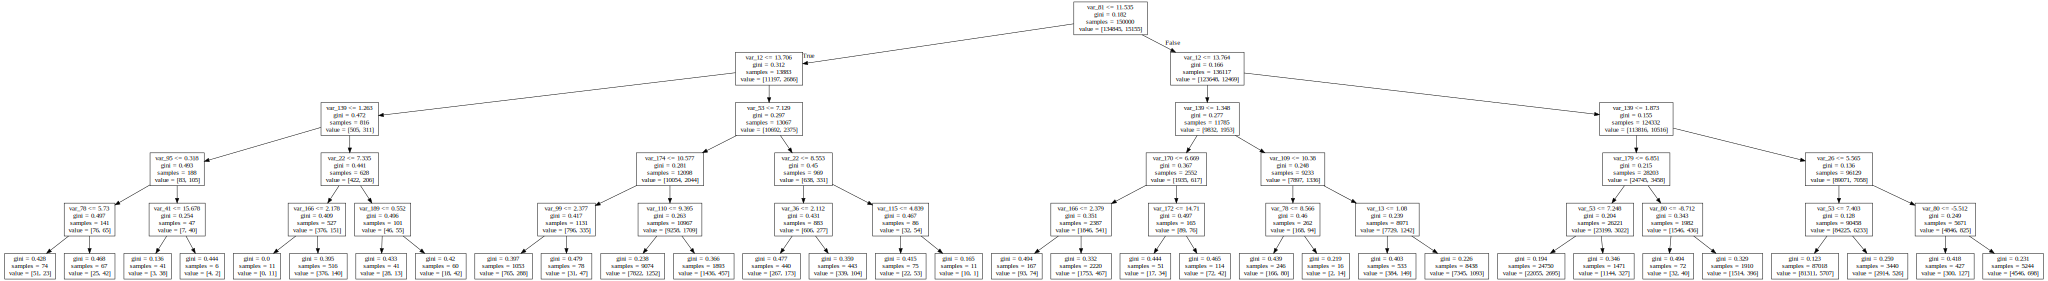

In [24]:
graphviz.Source(tree_graph)

As guidance to read the tree:

1. Leaves with children show their splitting criterion on the top
1. The pair of values at the bottom show the count of True values and False values for the target respectively, of data points in that node of the tree.
><font color="red"><b>Note: </b></font>
Yes **Var_81** are more effective on our model.

<a id="55"></a> <br>
## 5-5  Partial Dependence Plot
In this section, we see the impact of the main variables discovered in the previous sections by using the [pdpbox](https://pdpbox.readthedocs.io/en/latest/).

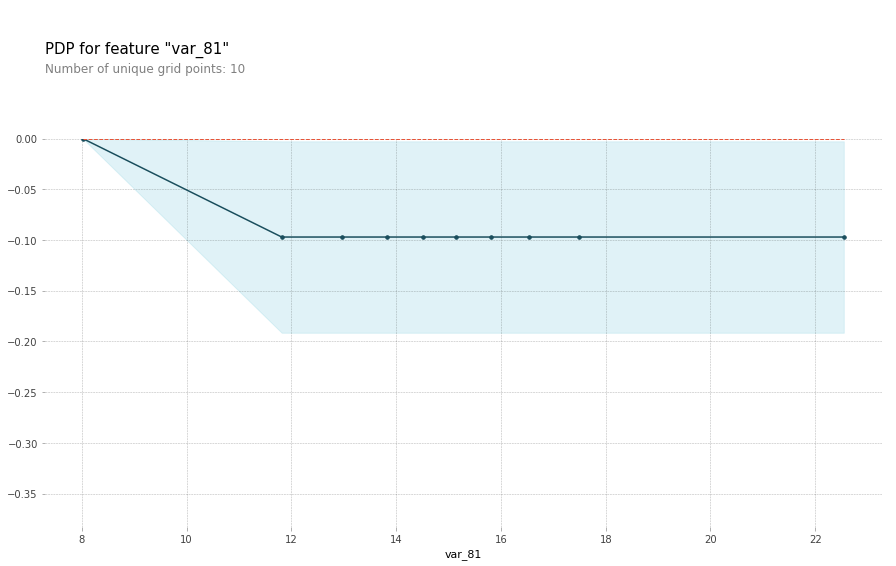

In [25]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_81')

# plot it
pdp.pdp_plot(pdp_goals, 'var_81')
plt.show()

<a id="56"></a> <br>
## 5-6 Chart analysis
1. The y axis is interpreted as change in the prediction from what it would be predicted at the baseline or leftmost value.
1. A blue shaded area indicates level of confidence

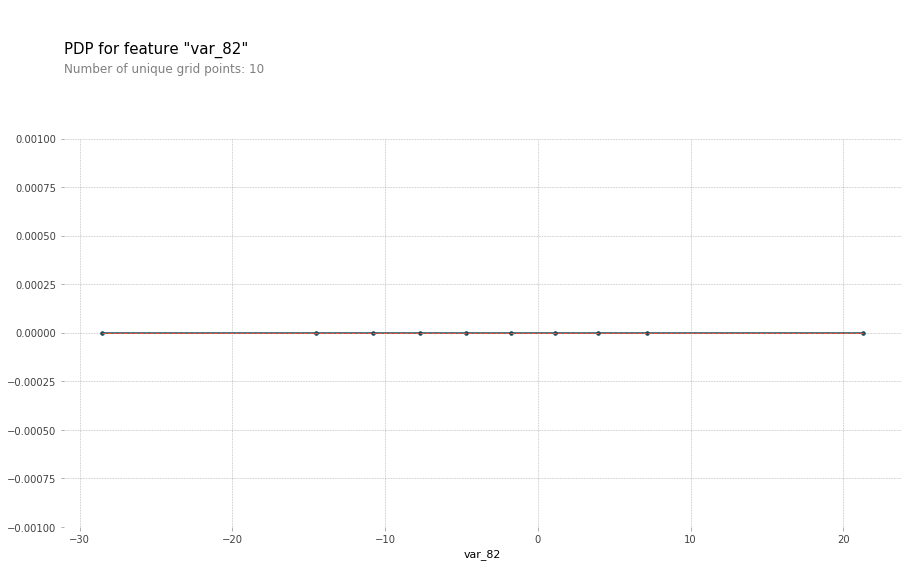

In [27]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_82')

# plot it
pdp.pdp_plot(pdp_goals, 'var_82')
plt.show()

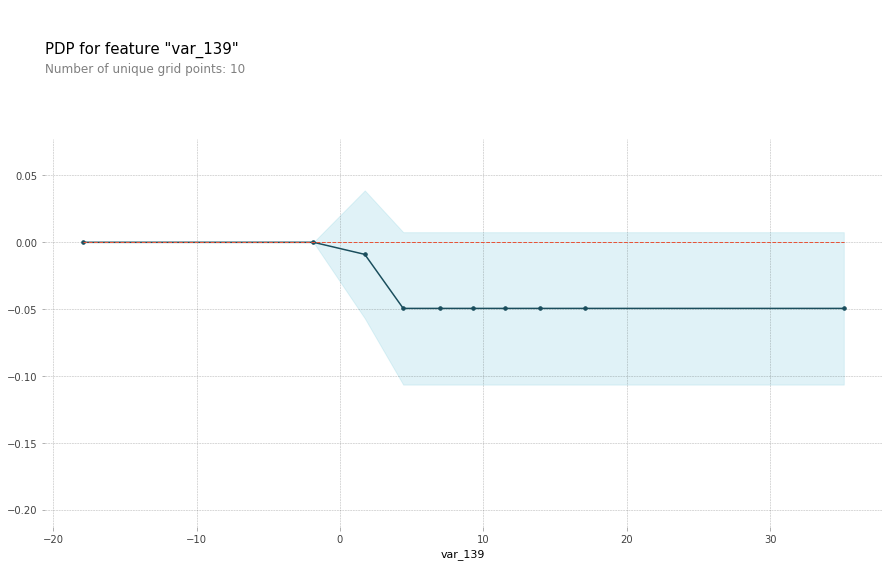

In [28]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_139')

# plot it
pdp.pdp_plot(pdp_goals, 'var_139')
plt.show()

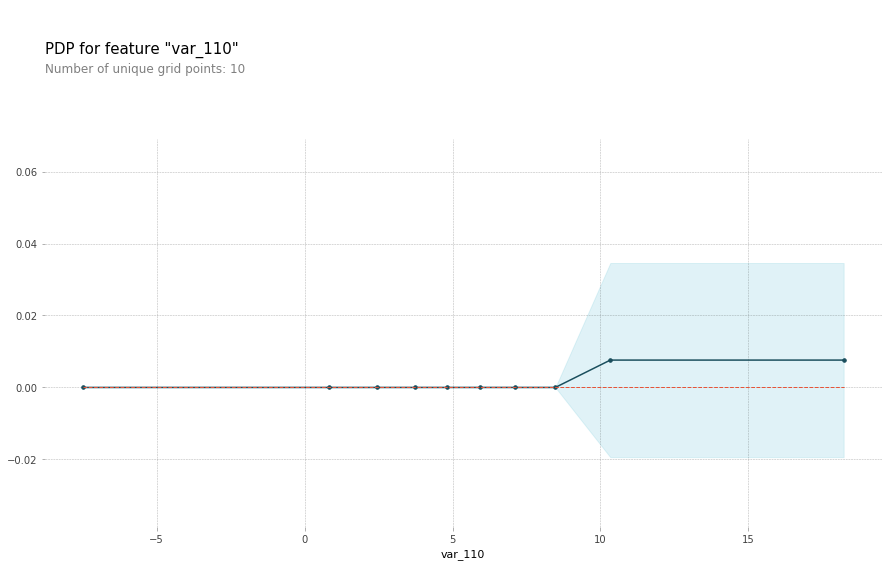

In [29]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_110')

# plot it
pdp.pdp_plot(pdp_goals, 'var_110')
plt.show()

<a id="57"></a> <br>
## 5-7 SHAP Values
**SHAP** (SHapley Additive exPlanations) is a unified approach to explain the output of **any machine learning model**. SHAP connects game theory with local explanations, uniting several previous methods [1-7] and representing the only possible consistent and locally accurate additive feature attribution method based on expectations (see the SHAP NIPS paper for details).

<img src='https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/shap_diagram.png' width=400 height=400>
[image credits](https://github.com/slundberg/shap)
><font color="red"><b>Note: </b></font>
Shap can answer to this qeustion : **how the model works for an individual prediction?**

In [30]:
row_to_show = 5
data_for_prediction = val_X.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

rfc_model.predict_proba(data_for_prediction_array);

In [31]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(rfc_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

If you look carefully at the code where we created the SHAP values, you'll notice we reference Trees in  **shap.TreeExplainer(my_model)**. But the SHAP package has explainers for every type of model.

1. shap.DeepExplainer works with Deep Learning models.
1. shap.KernelExplainer works with all models, though it is slower than other Explainers and it offers an approximation rather than exact Shap values.

In [32]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

In [33]:
# Calculate Shap values
#shap_values = explainer.shap_values(val_X)